In [1]:
import numpy as np
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import time
from scipy.spatial import distance
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from scipy.ndimage.measurements import label

%matplotlib inline

In [2]:
### LOAD FILES ###
vehicles_source = './data/vehicles/*'
vehicles_files = glob.glob(vehicles_source)
vehicles = []
for i, filename in enumerate(vehicles_files):
    img_files = glob.glob(filename + "/*.png")
    for j, imagename in enumerate(img_files):
        image = cv2.imread(imagename)
        if image == None:
            print("Something wrong with " + filename + "/" + imagename)
            continue
        vehicles.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

non_vehicles_source = './data/non-vehicles/*'
non_vehicles_files = glob.glob(non_vehicles_source)
non_vehicles = []
for i, filename in enumerate(non_vehicles_files):
    img_files = glob.glob(filename + "/*.png")
    for j, imagename in enumerate(img_files):
        image = cv2.imread(imagename)
        if image == None:
            print("Something wrong with " + filename + "/" + imagename)
            continue
        non_vehicles.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

/home/kzon/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Something wrong with ./data/vehicles/KITTI_extracted/./data/vehicles/KITTI_extracted/580.png


/home/kzon/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:21: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


8791 images of vehicles
8968 images of non-vehicles
Example images of a car image and non-car image:


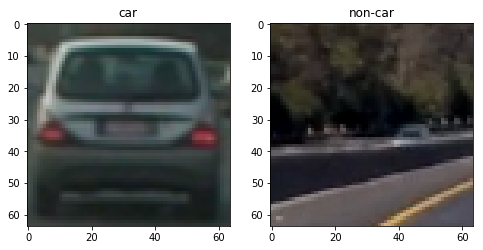

In [3]:
print(str(len(vehicles)) + " images of vehicles")
print(str(len(non_vehicles)) + " images of non-vehicles")
test_car = vehicles[0]
test_non_car = non_vehicles[0]
print("Example images of a car image and non-car image:")
plt.figure(figsize=(8,8))
plt.subplot(121).set_title("car")
plt.imshow(test_car)
plt.subplot(122).set_title("non-car")
plt.imshow(test_non_car)

In [4]:
### METHODS ###
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for image in imgs:
        file_features = []
        feature_image = np.copy(image)
        if color_space != 'RGB':
            feature_image=cv2.cvtColor(feature_image, eval('cv2.COLOR_RGB2' + color_space))
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))

    return features

### extract features for color_hist and bin_spatial
def extract_hist_bin_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    features = []
    for img in imgs:
        if cspace!= 'RGB':
            img=cv2.cvtColor(img, eval('cv2.COLOR.RGB2' + cspace))
        f1 = bin_spatial(img, size=spatial_size)
        f2 = color_hist(img, hist_bins, hist_range)
        features.append(np.concatenate((f1, f2)))
    return features

### extract hog features
def extract_hog_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    for image in imgs:
        feature_image = np.copy(image)
        if cspace != 'RGB':
            feature_image = cv2.cvtColor(feature_image, eval("cv2.COLOR_RGB2" + cspace))

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        features.append(hog_features)

    return features

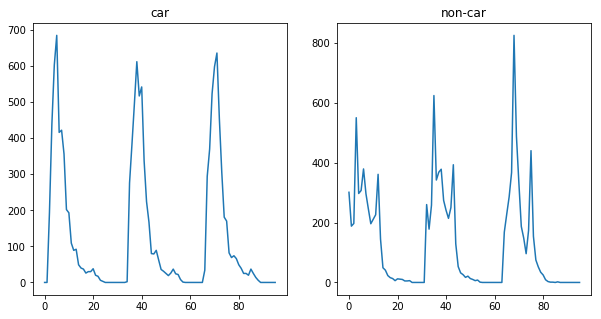

In [5]:
### COLOR HIST ###
feature_vec_car = color_hist(test_car, nbins=32, bins_range=(0, 256))
feature_vec_non_car = color_hist(test_non_car, nbins=32, bins_range=(0, 256))

# Plot features
plt.figure(figsize=(10,5))
plt.title('Color hist Features')
plt.subplot(121).set_title("car")
plt.plot(feature_vec_car)
plt.subplot(122).set_title("non-car")
plt.plot(feature_vec_non_car)

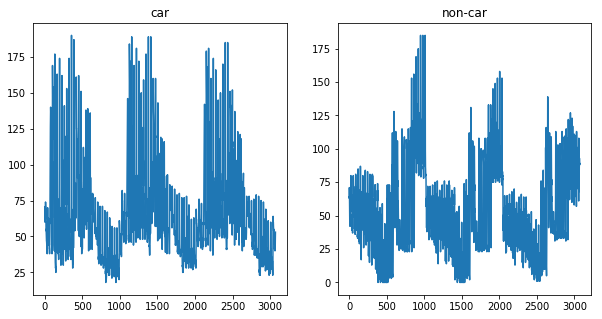

In [6]:
### BIN SPATIAL ###
feature_vec_car = bin_spatial(test_car, size=(32, 32))
feature_vec_non_car = bin_spatial(test_non_car, size=(32, 32))

# Plot features
plt.figure(figsize=(10,5))
plt.title('Spatially Binned Features')
plt.subplot(121).set_title("car")
plt.plot(feature_vec_car)
plt.subplot(122).set_title("non-car")
plt.plot(feature_vec_non_car)

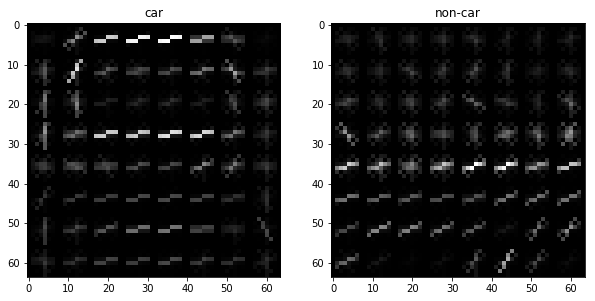

In [7]:
### APPLY HOG ###
orient = 9
pix_per_cell = 8
cell_per_block = 2
features_car, hog_image_car = get_hog_features(cv2.cvtColor(test_car, cv2.COLOR_RGB2GRAY), orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

features_non_car, hog_image_non_car = get_hog_features(cv2.cvtColor(test_non_car, cv2.COLOR_RGB2GRAY), orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot visualizations
plt.figure(figsize=(10,5))
plt.title('HOG Features')
plt.subplot(121).set_title("car")
plt.imshow(hog_image_car, cmap='gray')
plt.subplot(122).set_title("non-car")
plt.imshow(hog_image_non_car, cmap='gray')

In [17]:
### PREPARING TO TRAIN AND TRAIN LINEAR SVC ###
sample_size = 1000
cars = vehicles[:]
notcars = non_vehicles[:]

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [256, None] # Min and max in y to search in slide_window()

print("Extracting features...")
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("Scaling...")
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print("Splitting data...")
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

#svc = LinearSVC()
svc = SVC(kernel='linear', C=0.001, gamma=0.001)
print("Started training...")
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Extracting features...
Scaling...
Splitting data...
Feature vector length: 6108
Started training...
95.73 Seconds to train SVC...
Test Accuracy of SVC =  0.9904


In [18]:
#parameters = {'kernel':('linear', 'rbf'), 'C':[0.001,0.01, 0.1], 'gamma': [0.001, 0.01, 0.1]}
#svr = SVC()
#clf = GridSearchCV(svr, parameters, verbose=2)
#clf.fit(X_train, y_train)
#print(clf.best_params_)

In [29]:
### SLIDING WINDOWS ###
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, 
                  orient, pix_per_cell, cell_per_block, 
                  spatial_size, hist_bins, cspace="RGB"):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if cspace != "RGB":
        ctrans_tosearch = cv2.cvtColor(img_tosearch, eval("cv2.COLOR_RGB2" + cspace))
    else:
        ctrans_tosearch = np.copy(img_tosearch)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
            #if 1 == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, bboxes

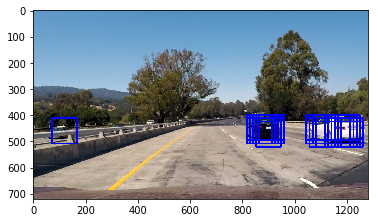

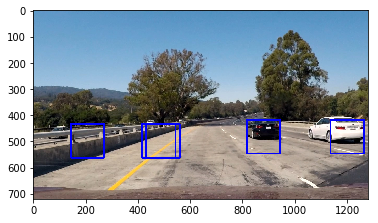

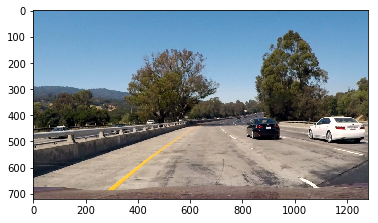

In [30]:
### TEST of find_cars method, without checking for false positives ###
ystart = 400
ystop = 532
scale = 1.5

test_image = cv2.cvtColor(cv2.imread('./test_images/test1.jpg'), cv2.COLOR_BGR2RGB)

out_img, box_list = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
plt.figure()
plt.imshow(out_img)

ystart = 418
ystop = 640
scale = 2

out_img, b_list = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
box_list = box_list + b_list
plt.figure()
plt.imshow(out_img)
ystart = 468
ystop = 692
scale = 2.5

out_img, b_list = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
box_list = box_list + b_list
plt.figure()
plt.imshow(out_img)

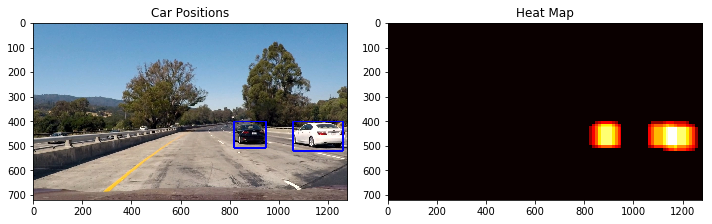

In [21]:
### TODO: IMPLEMENT HEAT POINTS AND FINAL RECT DRAWING ###
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def remove_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] -= 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heat = np.zeros_like(test_image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [22]:
class Detection():
    def __init__(self, n_frames=3):
        self.previous_detections = []
        self.n_frames = n_frames
        
    # check if detection is in area where it should appear only if it appeared in previous frames
    def __region_of_interest(self, box_list, heatmap):
        ### define region of impossible to get new cars if not in previous
        top_left = (300, 400)
        bottom_right = (1000, 625)
        for box in box_list:
            if self.__in_region(box, top_left, bottom_right):
                if not self.__found_previous(box, 15):
                    heatmap = remove_heat(heatmap, [box])
                else:
                    heatmap = add_heat(heatmap, [box])
        return heatmap
    
    # helper method for __region_of_interest
    def __in_region(self, box, top_left, bottom_right):
        if box[0][0] >= top_left[0] and box[1][0] <= bottom_right[0] and box[0][1] >= top_left[1] and box[1][1] <= bottom_right[1]:
            return True
        return False
    
    # check if there were previous detections of given object - helper method for __region_of_interest
    def __found_previous(self, box, max_dist):
        search_start = 0 if len(self.previous_detections) < self.n_frames else -self.n_frames
        found = False
        for prev_det in self.previous_detections[search_start:]:
            found = False
            for prev_box in prev_det:
                dist1 = distance.euclidean(prev_box[0], box[0])
                dist2 = distance.euclidean(prev_box[1], box[1])
                if dist1 > 0 and dist1 < max_dist and dist2 > 0 and dist2 < max_dist \
                    and prev_box[0][0] >= box[0][0] and prev_box[0][1] >= box[0][1] \
                    and prev_box[1][0] >= box[1][0] and prev_box[1][1] >= box[1][1]:
                    found=True
            if not found:
                return False
        return found
                          
        
    def process_image(self, image):
        ystart = 400
        ystop = 532
        scale = 1.5
        out_img, box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
        ystart = 418
        ystop = 640
        scale = 2
        out_img, b_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
        box_list = box_list + b_list
        ystart = 468
        ystop = 692
        scale = 2.5
        out_img, b_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
        box_list = box_list + b_list
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        
        if len(self.previous_detections) > self.n_frames:
            previous_dets = self.previous_detections[-self.n_frames:]
        else:
            previous_dets = self.previous_detections[:]
        for boxes in previous_dets:
            heat = add_heat(heat, boxes)
        heat[heat > 0] = 1
        heat = add_heat(heat,box_list)
        heat = self.__region_of_interest(box_list, heat)
        heat = apply_threshold(heat,3)
        heatmap = np.clip(heat, 0, 255)
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        if len(box_list) > 0:
            self.previous_detections.append(box_list)
        return draw_img

In [25]:
from moviepy.editor import VideoFileClip
detection = Detection(3)
out_clip = 'out2.mp4'
clip = VideoFileClip('project_video.mp4')
#clip = clip.subclip(0, 3)
processed_clip = clip.fl_image(detection.process_image)
processed_clip.write_videofile(out_clip, audio=False)
print("Output saved in " + out_clip)

[MoviePy] >>>> Building video out2.mp4
[MoviePy] Writing video out2.mp4


100%|█████████▉| 1260/1261 [1:53:47<00:05,  5.42s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out2.mp4 

Output saved in out2.mp4
